Kernel : base (Python 3.9.7) conda environnement

# I. RECUP DF7 et mise en forme

Installer packages/librairies nécessaires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
from os import listdir
import missingno as msno
from zipfile import ZipFile
import requests
import math
from numpy import loadtxt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from sklearn.metrics import silhouette_score, adjusted_rand_score
from matplotlib import offsetbox

import datetime

from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

palette

In [2]:
jaune ='#FFCA18'
rouge ='#88001B'
bleu ='#000064'
vert ='#055D00'
choco = '#4b2312'
orange = '#FF6103'
magenta = '#FF00FF'
pastel = ['#FFE06F','#FF9594','#78CF80','#FFB178','#A7B9FF','#FDE8D8']
pastel2 = [rouge, jaune, bleu, vert, choco, orange, magenta]

Definir l'environnement de travail

In [3]:
path_to_dir=os.path.abspath(os.getcwd())

Créer un sous-dossier 'images' dans le dossier de travail

In [4]:
directory = 'images'
images = os.path.join(path_to_dir, directory)

try: 
    os.mkdir(images) 
except OSError as error: 
    print(error)

[WinError 183] Impossible de créer un fichier déjà existant: 'c:\\Users\\denis\\OneDrive\\Documents\\Denis\\Formation_OpenClassRooms\\Projet5\\images'


Ouvrir df7

In [5]:
def csv_files(path_to_dir=f'{path_to_dir}/export', suffix=".csv"):
    filenames = listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]


csv_files()

['df13.csv', 'df7.csv', 'df8.csv']

In [6]:
df7 = pd.read_csv('export/df7.csv', sep=',',quotechar='"')
df7.head(3)

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_lat,geolocation_lng,review_score,...,payment_value,payment_installments,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,-23.155308,-47.084074,4.0,...,146.87,2.0,0,0,0,1,0,0,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,-23.155308,-47.084074,5.0,...,335.48,8.0,0,0,0,1,0,0,0,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,-23.155308,-47.084074,5.0,...,157.73,7.0,0,0,0,1,0,0,0,0


In [7]:
len(set(df7['customer_unique_id'])), len(set(df7['customer_id']))

(96096, 99441)

In [8]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99441 non-null  object 
 1   customer_unique_id             99441 non-null  object 
 2   order_id                       99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_delivered_carrier_date   97658 non-null  object 
 5   order_delivered_customer_date  96476 non-null  object 
 6   order_estimated_delivery_date  99441 non-null  object 
 7   geolocation_lat                99441 non-null  float64
 8   geolocation_lng                99441 non-null  float64
 9   review_score                   98673 non-null  float64
 10  payment_sequential             99440 non-null  float64
 11  payment_value                  99440 non-null  float64
 12  payment_installments           99440 non-null 

Creation des new features

In [9]:
df8 = df7.copy()

In [10]:
current = np.datetime64(datetime.datetime.now())

Convertir les col date (txt) en datetime

In [11]:
df8["order_purchase_timestamp"] = pd.to_datetime(df8["order_purchase_timestamp"])
df8["order_delivered_carrier_date"] = pd.to_datetime(df8["order_delivered_carrier_date"])
df8["order_delivered_customer_date"] = pd.to_datetime(df8["order_delivered_customer_date"])
df8["order_estimated_delivery_date"] = pd.to_datetime(df8["order_estimated_delivery_date"])

In [12]:
df8.insert(4, 'last_purchase', current-df8['order_purchase_timestamp'])
df8.insert(8, 'delta_delivering', df8['order_delivered_customer_date']-df8['order_purchase_timestamp'])

# II. Nettoyage df8 et gestion des NaN

In [13]:
df9 = df8.copy()

In [14]:
df9.columns.get_loc('order_status_approved')

15

In [15]:
df9.columns

Index(['customer_id', 'customer_unique_id', 'order_id',
       'order_purchase_timestamp', 'last_purchase',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'delta_delivering', 'geolocation_lat',
       'geolocation_lng', 'review_score', 'payment_sequential',
       'payment_value', 'payment_installments', 'order_status_approved',
       'order_status_canceled', 'order_status_created',
       'order_status_delivered', 'order_status_invoiced',
       'order_status_processing', 'order_status_shipped',
       'order_status_unavailable'],
      dtype='object')

In [16]:
df9 = df9.drop(columns=df9.columns[15:])
df9 = df9.drop(columns=['customer_id', 'order_delivered_carrier_date', 'order_estimated_delivery_date'])

In [17]:
df9.head(3)

,customer_unique_id,order_id,order_purchase_timestamp,last_purchase,order_delivered_customer_date,delta_delivering,geolocation_lat,geolocation_lng,review_score,payment_sequential,payment_value,payment_installments
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2142 days 17:48:16.278200,2017-05-25 10:35:35,8 days 19:30:00,-23.155308,-47.084074,4.0,1.0,146.87,2.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,1901 days 12:05:27.278200,2018-01-29 12:41:19,16 days 15:52:55,-23.155308,-47.084074,5.0,1.0,335.48,8.0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,1774 days 16:46:06.278200,2018-06-14 17:58:51,26 days 01:51:06,-23.155308,-47.084074,5.0,1.0,157.73,7.0


In [18]:
df9.shape

(99441, 12)

Convertir col dates (txt) en datetime

In [19]:
df9["order_purchase_timestamp"] = pd.to_datetime(df9["order_purchase_timestamp"])
df9["order_delivered_customer_date"] = pd.to_datetime(df9["order_delivered_customer_date"])

In [ ]:
df9.describe().T

,count,mean,std,min,25%,50%,75%,max
last_purchase,99441,1909 days 16:51:00.159592960,153 days 16:03:38.785401016,1619 days 08:03:54.936174,1785 days 09:51:56.936174016,1891 days 02:29:36.936174016,2019 days 10:47:53.936174016,2392 days 04:18:53.936174
delta_delivering,96476,12 days 13:24:31.879068369,9 days 13:07:00.181125305,0 days 12:48:07,6 days 18:23:37.250000,10 days 05:13:34,15 days 17:17:16.250000,209 days 15:05:12
geolocation_lat,99441.0,-21.166347,5.50597,-29.679191,-23.155308,-23.155308,-19.864647,2.7171
geolocation_lng,99441.0,-46.210262,3.884026,-68.451852,-47.084074,-47.084074,-44.421615,-35.758866
review_score,98673.0,4.086793,1.346274,1.0,4.0,5.0,5.0,5.0
payment_sequential,99440.0,1.045515,0.382177,1.0,1.0,1.0,1.0,29.0
payment_value,99440.0,160.990267,221.951257,0.0,62.01,105.29,176.97,13664.08
payment_installments,99440.0,2.930521,2.715685,0.0,1.0,2.0,4.0,24.0


# /!\ dropna()

In [ ]:
df10 = df9.dropna()

In [ ]:
df10.describe().T

,count,mean,std,min,25%,50%,75%,max
last_purchase,95829,1907 days 23:05:45.722230496,152 days 21:14:49.814699854,1668 days 10:33:35.936174,1784 days 01:48:37.936174016,1889 days 02:03:55.936174016,2017 days 15:14:11.936174016,2363 days 15:49:22.936174
delta_delivering,95829,12 days 12:24:12.796522973,9 days 11:02:20.050401931,0 days 12:48:07,6 days 18:11:21,10 days 04:56:48,15 days 15:56:12,208 days 08:26:32
geolocation_lat,95829.0,-21.18131,5.496176,-29.679191,-23.155308,-23.155308,-19.864647,2.7171
geolocation_lng,95829.0,-46.226887,3.882426,-68.451852,-47.084074,-47.084074,-44.421615,-35.758866
review_score,95829.0,4.156056,1.283711,1.0,4.0,5.0,5.0,5.0
payment_sequential,95829.0,1.045143,0.371209,1.0,1.0,1.0,1.0,26.0
payment_value,95829.0,159.590528,217.507603,9.59,61.84,105.28,176.16,13664.08
payment_installments,95829.0,2.925722,2.710221,0.0,1.0,2.0,4.0,24.0


In [ ]:
df10 = df10[df10['payment_installments']>0]

In [ ]:
df10.shape, df9.shape

((95827, 12), (99441, 12))

# Rename col

In [ ]:
df11 = df10.rename(columns={'customer_unique_id': "Customer", 'review_score': 'Satisfaction',
                           'last_purchase': 'Recency', 'payment_value': 'Money',
                           'delta_delivering': 'Delta_deliv', 'payment_installments': 'Pay_installments',
                           'payment_sequential' : 'Pay_sequential',
                           'geolocation_lat': 'Lat', 'geolocation_lng' : 'Long'})

In [ ]:
df11.head(3)

,Customer,order_id,order_purchase_timestamp,Recency,order_delivered_customer_date,Delta_deliv,Lat,Long,Satisfaction,Pay_sequential,Money,Pay_installments
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2138 days 10:28:37.936174,2017-05-25 10:35:35,8 days 19:30:00,-23.155308,-47.084074,4.0,1.0,146.87,2.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,1897 days 04:45:48.936174,2018-01-29 12:41:19,16 days 15:52:55,-23.155308,-47.084074,5.0,1.0,335.48,8.0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,1770 days 09:26:27.936174,2018-06-14 17:58:51,26 days 01:51:06,-23.155308,-47.084074,5.0,1.0,157.73,7.0


# Changement types des col dates

In [ ]:
df11['Recency'] = df11['Recency'].astype('timedelta64[D]').astype(int)
df11['Delta_deliv'] = df11['Delta_deliv'].astype('timedelta64[D]').astype(int)

# III EDA

In [ ]:
df12 = df11.copy()

In [ ]:
df12.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,95827.0,1907.567784,152.888394,1668.000000,1784.000000,1889.000000,2017.000000,2363.000000
Delta_deliv,95827.0,12.052438,9.465568,0.000000,6.000000,10.000000,15.000000,208.000000
Lat,95827.0,-21.181374,5.496166,-29.679191,-23.155308,-23.155308,-19.864647,2.717100
Long,95827.0,-46.226948,3.882406,-68.451852,-47.084074,-47.084074,-44.421615,-35.758866
Satisfaction,95827.0,4.156038,1.283719,1.000000,4.000000,5.000000,5.000000,5.000000
Pay_sequential,95827.0,1.045123,0.371187,1.000000,1.000000,1.000000,1.000000,26.000000
Money,95827.0,159.591891,217.509608,9.590000,61.840000,105.280000,176.160000,13664.080000
Pay_installments,95827.0,2.925783,2.710216,1.000000,1.000000,2.000000,4.000000,24.000000


In [ ]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95827 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       95827 non-null  object        
 1   order_id                       95827 non-null  object        
 2   order_purchase_timestamp       95827 non-null  datetime64[ns]
 3   Recency                        95827 non-null  int32         
 4   order_delivered_customer_date  95827 non-null  datetime64[ns]
 5   Delta_deliv                    95827 non-null  int32         
 6   Lat                            95827 non-null  float64       
 7   Long                           95827 non-null  float64       
 8   Satisfaction                   95827 non-null  float64       
 9   Pay_sequential                 95827 non-null  float64       
 10  Money                          95827 non-null  float64       
 11  Pay_installment

In [ ]:
df12.isna().sum().sum()

0

<AxesSubplot:xlabel='order_delivered_customer_date', ylabel='Count'>

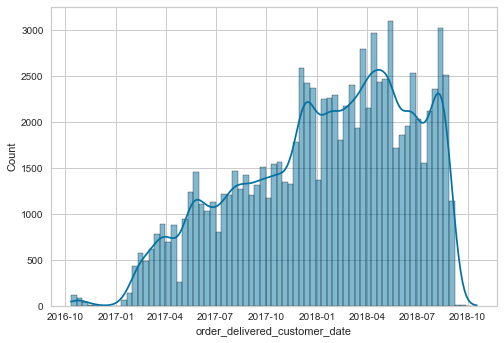

In [ ]:
sns.histplot(df12['order_delivered_customer_date'], kde=True)

Creation new feature delta_time

In [ ]:
delta_time = df12['order_delivered_customer_date'].max()- df12['order_delivered_customer_date'].min()

In [ ]:
delta_time

Timedelta('735 days 23:36:14')

In [ ]:
df12.insert(3, 'Delta_time', (df12['order_delivered_customer_date'] - df12['order_delivered_customer_date'].min()))

In [ ]:
df12['Delta_time'] = df12['Delta_time'].astype('timedelta64[D]').astype(int)

In [ ]:
df12.head(10)

,Customer,order_id,order_purchase_timestamp,Delta_time,Recency,order_delivered_customer_date,Delta_deliv,Lat,Long,Satisfaction,Pay_sequential,Money,Pay_installments
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,225,2138,2017-05-25 10:35:35,8,-23.155308,-47.084074,4.0,1.0,146.87,2.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,474,1897,2018-01-29 12:41:19,16,-23.155308,-47.084074,5.0,1.0,335.48,8.0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,611,1770,2018-06-14 17:58:51,26,-23.155308,-47.084074,5.0,1.0,157.73,7.0
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,533,1837,2018-03-28 16:04:25,14,-23.155308,-47.084074,5.0,1.0,173.30,1.0
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,667,1699,2018-08-09 20:55:48,11,-23.155308,-47.084074,5.0,1.0,252.25,8.0
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:14:31,352,2017,2017-09-28 17:32:43,13,-27.222486,-49.617937,5.0,1.0,282.21,1.0
6,addec96d2e059c80c30fe6871d30d177,36e694cf4cbc2a4803200c35e84abdc4,2018-02-19 14:38:35,497,1859,2018-02-20 16:25:51,1,-23.155308,-47.084074,5.0,1.0,22.77,1.0
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:29:02,411,1954,2017-11-27 12:44:36,10,-19.864647,-44.421615,3.0,1.0,36.01,3.0
8,1175e95fb47ddff9de6b2b06188f7e0d,1ebeea841c590e86a14a0d7a48e7d062,2018-01-18 12:35:44,472,1891,2018-01-26 15:17:57,8,-24.793607,-50.879662,5.0,1.0,39.10,1.0
9,9afe194fb833f79e300e37e580171f22,7433cbcc783205509d66a5260da5b574,2018-01-08 11:22:34,459,1901,2018-01-13 14:51:55,5,-19.864647,-44.421615,5.0,1.0,122.47,1.0


Convert float to int

In [ ]:
df12['Pay_installments'] = df12['Pay_installments'].astype(int)
df12['Pay_sequential'] = df12['Pay_sequential'].astype(int)
df12['Satisfaction'] = df12['Satisfaction'].astype(int)

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='Count'>

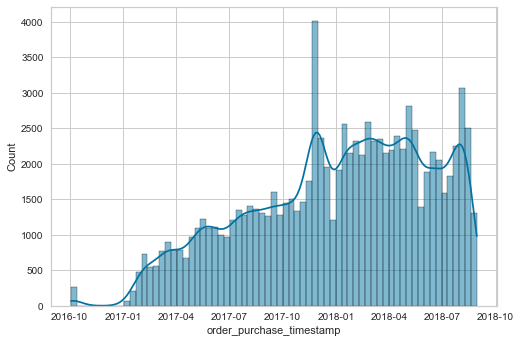

In [ ]:
sns.histplot(df12["order_purchase_timestamp"], kde=True)

<AxesSubplot:xlabel='Delta_time', ylabel='Count'>

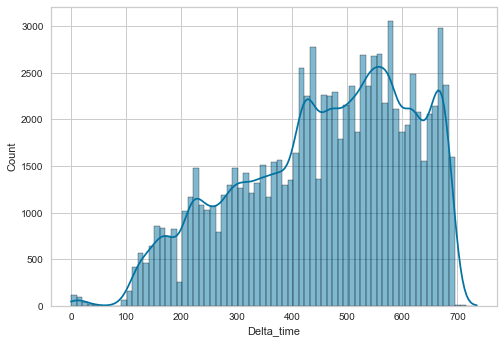

In [ ]:
sns.histplot(df12["Delta_time"], kde=True)

In [ ]:
df12["Delta_time"].max()

735

# Supprimer les 13 lignes pour lesquelles delta_deliv est nulles

In [ ]:
df12 = df12[df12['Delta_deliv']>0]

In [ ]:
df12.head(3)

,Customer,order_id,order_purchase_timestamp,Delta_time,Recency,order_delivered_customer_date,Delta_deliv,Lat,Long,Satisfaction,Pay_sequential,Money,Pay_installments
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,225,2138,2017-05-25 10:35:35,8,-23.155308,-47.084074,4,1,146.87,2
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,474,1897,2018-01-29 12:41:19,16,-23.155308,-47.084074,5,1,335.48,8
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,611,1770,2018-06-14 17:58:51,26,-23.155308,-47.084074,5,1,157.73,7


In [ ]:
df12.describe().T

,count,mean,std,min,25%,50%,75%,max
Delta_time,95814.0,459.721533,152.308220,0.000000,349.000000,479.000000,581.000000,735.000000
Recency,95814.0,1907.562747,152.885284,1668.000000,1784.000000,1889.000000,2017.000000,2363.000000
Delta_deliv,95814.0,12.054074,9.465169,1.000000,6.000000,10.000000,15.000000,208.000000
Lat,95814.0,-21.181216,5.496433,-29.679191,-23.155308,-23.155308,-19.864647,2.717100
Long,95814.0,-46.226951,3.882586,-68.451852,-47.084074,-47.084074,-44.421615,-35.758866
Satisfaction,95814.0,4.155426,1.284125,1.000000,4.000000,5.000000,5.000000,5.000000
Pay_sequential,95814.0,1.045119,0.371199,1.000000,1.000000,1.000000,1.000000,26.000000
Money,95814.0,159.590699,217.512806,9.590000,61.840000,105.280000,176.160000,13664.080000
Pay_installments,95814.0,2.925825,2.710330,1.000000,1.000000,2.000000,4.000000,24.000000


# III Creation d'une super fct

In [ ]:
df12.columns

Index(['Customer', 'order_id', 'order_purchase_timestamp', 'Delta_time',
       'Recency', 'order_delivered_customer_date', 'Delta_deliv', 'Lat',
       'Long', 'Satisfaction', 'Pay_sequential', 'Money', 'Pay_installments'],
      dtype='object')

In [ ]:
def simulation(cutoff = 500, step = 7, n_clust = 7, features_dropped=None, log = 'yes'):
    df = df12.copy()
    dd = df[df['Delta_time']==cutoff]
    max = df12["Delta_time"].max()
    fold = math.ceil((max-cutoff)/step)
    l = []
    scaler = StandardScaler()
    cutoff_date = dd.groupby('Delta_time').agg({'order_delivered_customer_date':'mean'}) # récup de la date du cutoff
    df0 = df[df['Delta_time']<= cutoff] # creation du df à t0 => modèle M0 de référence
    df0 = df0.groupby(by=['Customer'], as_index=False).agg({"Satisfaction":'mean', 
                                                                  'Recency': 'min',
                                                                  'order_id': 'count',
                                                                  'Money': 'sum',
                                                                  'Delta_deliv': 'mean',
                                                                  'Pay_installments': 'mean',
                                                                  'Pay_sequential' : 'mean',
                                                                  'Lat': 'mean',
                                                                  'Long': 'mean'})
    df0 = df0.rename(columns={'order_id': 'Frequency'})
    if log == 'yes':
        df0['Lat'] = df0['Lat'].apply(lambda x : x -5)
        df0['Lat'] = df0['Lat'].abs()
        df0['Long'] = df0['Long'].abs()
        df0.insert(1, 'Log2_Satisf', np.log2(df0.pop('Satisfaction')))
        df0.insert(3, 'Log2_Freq', np.log2(df0.pop('Frequency')))
        df0.insert(4, 'Log2_Money', np.log2(df0.pop('Money')))
        df0.insert(2, 'Log2_Recency', np.log2(df0.pop('Recency')))
        df0.insert(5, 'Log2_Delta_deliv', np.log2(df0.pop('Delta_deliv')))
        df0.insert(6, 'Log2_Pay_installments', np.log2(df0.pop('Pay_installments')))
        df0.insert(7, 'Log2_Pay_sequential', np.log2(df0.pop('Pay_sequential')))
        df0.insert(8, 'Log2_|Lat-5|', np.log2(df0.pop('Lat')))
        df0.insert(9, 'Log2_|Long|', np.log2(df0.pop('Long')))
    else:
        None
    if features_dropped == None:
        df_x0 =  df0.iloc[:,1:]
    else:
        df_x0 =  df0.iloc[:, 1:]
        df_x0 = df_x0.drop(columns = features_dropped)
    
    X0 = scaler.fit_transform(df_x0)
    model = KMeans(init='k-means++', random_state=42)
    #visualizer = KElbowVisualizer(model, k=(2,11), metric='calinski_harabasz', timings=False, locate_elbow=False)
    #visualizer.fit(X0)    # Fit the data to the visualizer
    #visualizer.poof(outpath="images/save_kmeans_Calinski_df0_FINAL.png")
    kmeans = KMeans(n_clusters = n_clust, init = "k-means++", random_state = 42)
    y_kmeans0 = kmeans.fit_predict(X0)
    df0.insert(0, 'KMeans', y_kmeans0)
    #fig = sns.pairplot(df0, hue='KMeans', palette=pastel2, corner=True)
    #plt.savefig('images/save_pairplot_df0_KMeans.png')
    
    l2 = [1]
    l3 = [len(df0)]
    count = [0]   
    for i in range(0, fold, 1): #creation des dfi (itération) selon le step
        if i==fold-1:
            #dfi = df[df['Delta_time']> (cutoff+i*step)]
            #dfi = df[df['Delta_time']> cutoff]
            dfi = df
        else:
            #dfi = df[(df['Delta_time']> (cutoff+i*step)) & (df['Delta_time'] <= (cutoff+(i+1)*step))]
            dfi = df[df['Delta_time'] <= (cutoff+(i+1)*step)]
        dfi = dfi.groupby(by=['Customer'], as_index=False).agg({"Satisfaction":'mean', 
                                                                  'Recency': 'min',
                                                                  'order_id': 'count',
                                                                  'Money': 'sum',
                                                                  'Delta_deliv': 'mean',
                                                                  'Pay_installments': 'mean',
                                                                  'Pay_sequential' : 'mean',
                                                                  'Lat': 'mean',
                                                                  'Long': 'mean'})
        dfi = dfi.rename(columns={'order_id': 'Frequency'})
        if log == 'yes':
            dfi['Lat'] = dfi['Lat'].apply(lambda x : x -5)
            dfi['Lat'] = dfi['Lat'].abs()
            dfi['Long'] = dfi['Long'].abs()
            dfi.insert(1, 'Log2_Satisf', np.log2(dfi.pop('Satisfaction')))
            dfi.insert(3, 'Log2_Freq', np.log2(dfi.pop('Frequency')))
            dfi.insert(4, 'Log2_Money', np.log2(dfi.pop('Money')))
            dfi.insert(2, 'Log2_Recency', np.log2(dfi.pop('Recency')))
            dfi.insert(5, 'Log2_Delta_deliv', np.log2(dfi.pop('Delta_deliv')))
            dfi.insert(6, 'Log2_Pay_installments', np.log2(dfi.pop('Pay_installments')))
            dfi.insert(7, 'Log2_Pay_sequential', np.log2(dfi.pop('Pay_sequential')))
            dfi.insert(8, 'Log2_|Lat-5|', np.log2(dfi.pop('Lat')))
            dfi.insert(9, 'Log2_|Long|', np.log2(dfi.pop('Long')))
        else:
            None
        if features_dropped == None:
            df_xi =  dfi.iloc[:,1:]
        else:
            df_xi =  dfi.iloc[:, 1:]
            df_xi = df_xi.drop(columns = features_dropped)
                  
        Xi = StandardScaler().fit_transform(df_xi)
        y_kmeans_i = KMeans(n_clusters = n_clust, init = "k-means++", random_state = 42).fit_predict(Xi) #fit avec modèle M1
        y_kmeans_pred = KMeans(n_clusters = n_clust, init = "k-means++", random_state = 42).fit(X0).predict(Xi)
        dfi.insert(0, 'KMeans_i', y_kmeans_i)
        dfi.insert(1, 'KMeans_pred', y_kmeans_pred)
        l.append(dfi)
        ARI = adjusted_rand_score(y_kmeans_i, y_kmeans_pred)
        l2.append(ARI)
        count.append((i+1)*step)
        l3.append(len(dfi))
    d = {'Nb_days': count, 'ARI': l2, 'Nb_customers':l3}
    df_ = pd.DataFrame(d)
    sns.lineplot(data = df_, x = 'Nb_days', y = 'ARI')
    return df_, cutoff_date, df0.columns

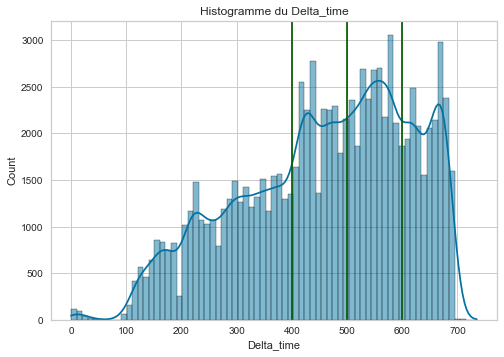

In [ ]:
sns.histplot(df12['Delta_time'], kde=True).set(title='Histogramme du Delta_time')
plt.axvline(x=400, color=vert)
plt.axvline(x=500, color=vert)
plt.axvline(x=600, color=vert)
#plt.axvline(x=650, color=rouge)

(    Nb_days       ARI  Nb_customers
 0         0  1.000000          5960
 1         7  0.702803          6462
 2        14  0.961244          7206
 3        21  0.854245          8124
 4        28  0.785739          9119
 ..      ...       ...           ...
 73      511  0.620083         92732
 74      518  0.616174         92734
 75      525  0.622820         92735
 76      532  0.623417         92736
 77      539  0.621591         92737
 
 [78 rows x 3 columns],
            order_delivered_customer_date
 Delta_time                              
 200              2017-04-30 09:34:46.100,
 Index(['KMeans', 'Customer', 'Log2_Satisf', 'Log2_Recency', 'Log2_Freq',
        'Log2_Money', 'Log2_Delta_deliv', 'Log2_Pay_installments',
        'Log2_Pay_sequential', 'Log2_|Lat-5|', 'Log2_|Long|'],
       dtype='object'))

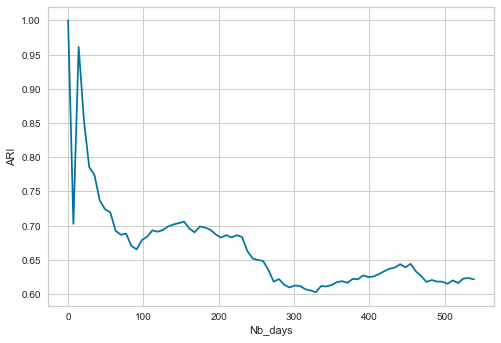

In [ ]:
simulation(cutoff = 200, step = 7, n_clust = 7, features_dropped=None, log='yes')

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         16934
 1         7  0.988486         17835
 2        14  0.987088         18705
 3        21  0.986128         19741
 4        28  0.980287         20540
 ..      ...       ...           ...
 59      413  0.775515         92733
 60      420  0.789481         92735
 61      427  0.789481         92735
 62      434  0.791060         92736
 63      441  0.783568         92737
 
 [64 rows x 3 columns],
            order_delivered_customer_date
 Delta_time                              
 300           2017-08-07 19:45:37.830688,
 Index(['KMeans', 'Customer', 'Log2_Satisf', 'Log2_Recency', 'Log2_Freq',
        'Log2_Money', 'Log2_Delta_deliv', 'Log2_Pay_installments',
        'Log2_Pay_sequential', 'Log2_|Lat-5|', 'Log2_|Long|'],
       dtype='object'))

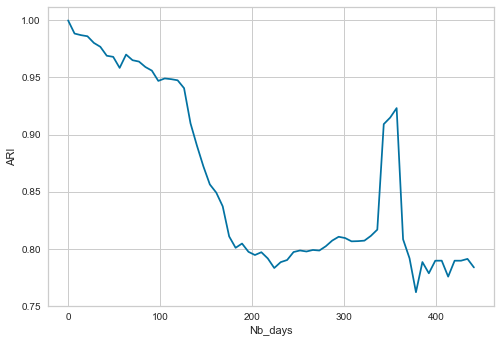

In [ ]:
simulation(cutoff = 300, step = 7, n_clust = 7, features_dropped=None, log='yes')

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         30079
 1         7  0.984176         31125
 2        14  0.986464         32516
 3        21  0.986173         34199
 4        28  0.960472         35988
 5        35  0.919085         37773
 6        42  0.905736         39075
 7        49  0.889363         40066
 8        56  0.879685         41600
 9        63  0.860912         42889
 10       70  0.865167         44425
 11       77  0.834448         46089
 12       84  0.830405         47516
 13       91  0.828532         48367
 14       98  0.817230         50073
 15      105  0.817942         51686
 16      112  0.817280         53122
 17      119  0.812369         54462
 18      126  0.805130         56064
 19      133  0.814648         57763
 20      140  0.810341         59297
 21      147  0.816062         61221
 22      154  0.824434         62973
 23      161  0.825673         64648
 24      168  0.827776         66134
 25      175  0.831077         68073
 

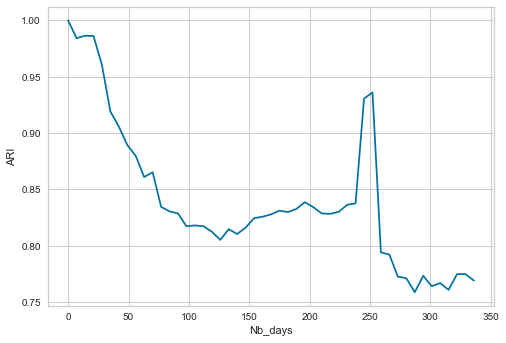

In [ ]:
simulation(cutoff = 400, step = 7, n_clust = 7, features_dropped=None, log='yes')

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         72875
 1         7  0.991949         74566
 2        14  0.990971         76029
 3        21  0.981933         77627
 4        28  0.974782         79087
 5        35  0.964843         80451
 6        42  0.851133         81878
 7        49  0.844768         82240
 8        56  0.790402         84010
 9        63  0.676145         85637
 10       70  0.656198         87352
 11       77  0.642800         89300
 12       84  0.650099         91169
 13       91  0.657418         92687
 14       98  0.651891         92713
 15      105  0.651434         92722
 16      112  0.655694         92732
 17      119  0.652119         92734
 18      126  0.663184         92735
 19      133  0.664512         92736
 20      140  0.657994         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Log2_Satisf', 'Log2_Recency

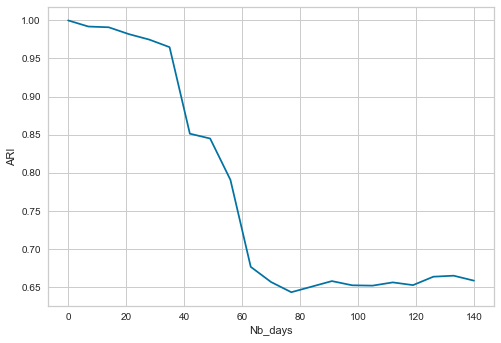

In [ ]:
simulation(cutoff = 600, step = 7, n_clust = 7, features_dropped=None, log='yes')

(   Nb_days       ARI  Nb_customers
 0        0  1.000000         72875
 1       15  0.991196         76384
 2       30  0.972327         79657
 3       45  0.847470         81936
 4       60  0.670233         85272
 5       75  0.639663         89212
 6       90  0.652880         92686
 7      105  0.651434         92722
 8      120  0.663184         92735
 9      135  0.657994         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Log2_Satisf', 'Log2_Recency', 'Log2_Freq',
        'Log2_Money', 'Log2_Delta_deliv', 'Log2_Pay_installments',
        'Log2_Pay_sequential', 'Log2_|Lat-5|', 'Log2_|Long|'],
       dtype='object'))

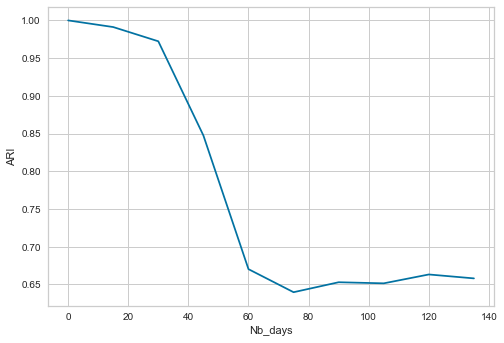

In [ ]:
simulation(cutoff = 600, step = 15, n_clust = 7, features_dropped=None, log='yes')

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         50651
 1         7  0.993814         52170
 2        14  0.984327         53629
 3        21  0.982777         55021
 4        28  0.980269         56638
 5        35  0.978018         58122
 6        42  0.974931         59975
 7        49  0.964623         61867
 8        56  0.953883         63542
 9        63  0.950923         65256
 10       70  0.948024         66881
 11       77  0.942501         68744
 12       84  0.942194         70737
 13       91  0.930760         72224
 14       98  0.927723         72763
 15      105  0.929018         74461
 16      112  0.922721         75942
 17      119  0.914902         77538
 18      126  0.908678         79013
 19      133  0.901553         80371
 20      140  0.814256         81813
 21      147  0.823021         82178
 22      154  0.799060         83910
 23      161  0.646096         85551
 24      168  0.651661         87261
 25      175  0.631518         89212
 

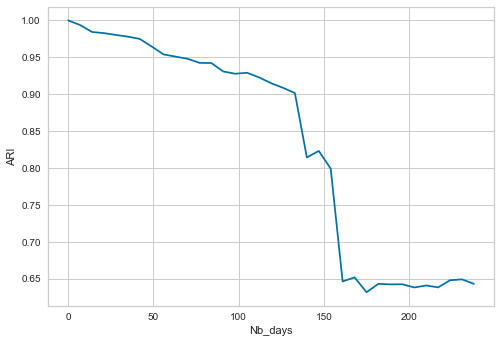

In [ ]:
simulation(cutoff = 500, step = 7, n_clust = 7, features_dropped=None, log='yes')

In [ ]:
simulation(cutoff = 400, step = 7, n_clust = 7, features_dropped=None, log='yes')

KeyboardInterrupt: 

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         72875
 1         7  0.986880         74566
 2        14  0.985754         76029
 3        21  0.989751         77627
 4        28  0.989147         79087
 5        35  0.594397         80451
 6        42  0.986350         81878
 7        49  0.988270         82240
 8        56  0.985093         84010
 9        63  0.983540         85637
 10       70  0.980102         87352
 11       77  0.977544         89300
 12       84  0.980187         91169
 13       91  0.980596         92687
 14       98  0.979563         92713
 15      105  0.977918         92722
 16      112  0.978268         92732
 17      119  0.973682         92734
 18      126  0.978693         92735
 19      133  0.973766         92736
 20      140  0.978719         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Log2_Satisf', 'Log2_Recency

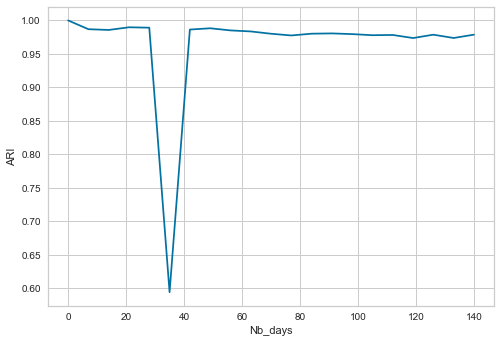

In [ ]:
simulation(cutoff = 600, step = 7, n_clust = 6, features_dropped=None, log='yes')

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         72875
 1         7  0.992770         74566
 2        14  0.565497         76029
 3        21  0.567421         77627
 4        28  0.994065         79087
 5        35  0.568743         80451
 6        42  0.566714         81878
 7        49  0.988676         82240
 8        56  0.984833         84010
 9        63  0.982372         85637
 10       70  0.571857         87352
 11       77  0.567163         89300
 12       84  0.566886         91169
 13       91  0.884470         92687
 14       98  0.564339         92713
 15      105  0.885817         92722
 16      112  0.564091         92732
 17      119  0.564284         92734
 18      126  0.567013         92735
 19      133  0.886894         92736
 20      140  0.886539         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Satisfaction', 'Recency', '

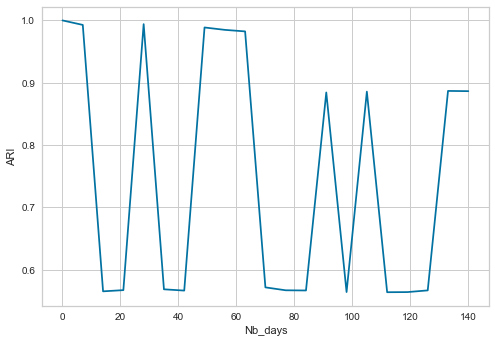

In [ ]:
simulation(cutoff = 600, step = 7, n_clust = 6, features_dropped=None, log=None)

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         72875
 1         7  0.992384         74566
 2        14  0.992376         76029
 3        21  0.994919         77627
 4        28  0.817261         79087
 5        35  0.991857         80451
 6        42  0.989794         81878
 7        49  0.987645         82240
 8        56  0.985749         84010
 9        63  0.982078         85637
 10       70  0.968433         87352
 11       77  0.889819         89300
 12       84  0.885911         91169
 13       91  0.894124         92687
 14       98  0.893834         92713
 15      105  0.893416         92722
 16      112  0.891871         92732
 17      119  0.891720         92734
 18      126  0.894360         92735
 19      133  0.892749         92736
 20      140  0.891418         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Satisfaction', 'Recency', '

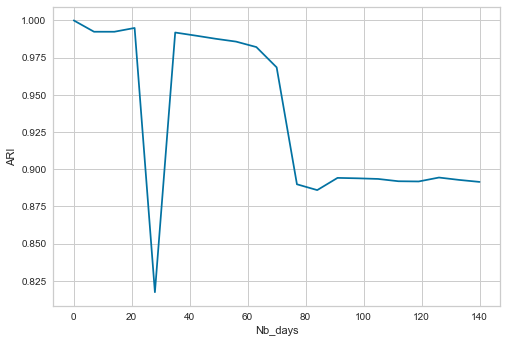

In [ ]:
simulation(cutoff = 600, step = 7, n_clust = 7, features_dropped=None, log=None)

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         30079
 1         7  0.920269         31125
 2        14  0.987422         32516
 3        21  0.920073         34199
 4        28  0.912612         35988
 5        35  0.908147         37773
 6        42  0.900245         39075
 7        49  0.894124         40066
 8        56  0.740439         41600
 9        63  0.882472         42889
 10       70  0.878576         44425
 11       77  0.771638         46089
 12       84  0.875889         47516
 13       91  0.873538         48367
 14       98  0.872922         50073
 15      105  0.869651         51686
 16      112  0.867203         53122
 17      119  0.863429         54462
 18      126  0.862395         56064
 19      133  0.853420         57763
 20      140  0.854443         59297
 21      147  0.851973         61221
 22      154  0.850824         62973
 23      161  0.845350         64648
 24      168  0.843466         66134
 25      175  0.843810         68073
 

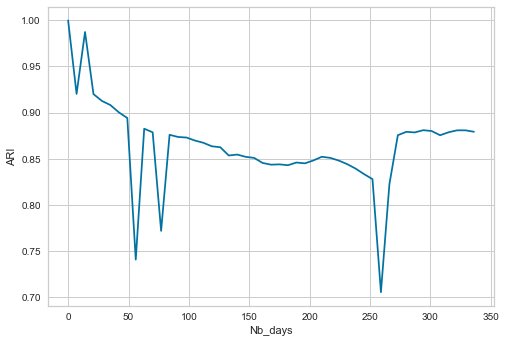

In [ ]:
simulation(cutoff = 400, step = 7, n_clust = 7, features_dropped=None, log=None)

(    Nb_days       ARI  Nb_customers
 0         0  1.000000         72875
 1         7  0.997830         74566
 2        14  0.994620         76029
 3        21  0.995716         77627
 4        28  0.991774         79087
 5        35  0.990949         80451
 6        42  0.990362         81878
 7        49  0.987491         82240
 8        56  0.974678         84010
 9        63  0.979772         85637
 10       70  0.971619         87352
 11       77  0.864092         89300
 12       84  0.843319         91169
 13       91  0.849609         92687
 14       98  0.850294         92713
 15      105  0.856057         92722
 16      112  0.859598         92732
 17      119  0.849099         92734
 18      126  0.850710         92735
 19      133  0.851585         92736
 20      140  0.858326         92737,
            order_delivered_customer_date
 Delta_time                              
 600        2018-06-04 02:11:47.227272704,
 Index(['KMeans', 'Customer', 'Satisfaction', 'Recency', '

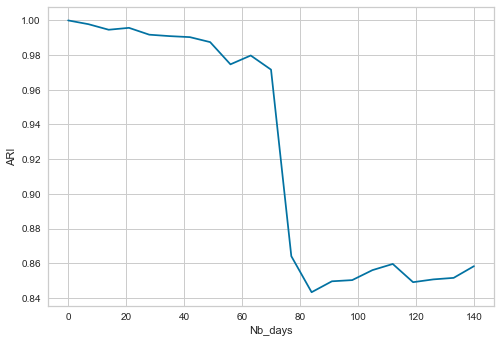

In [ ]:
simulation(cutoff = 600, step = 7, n_clust = 7, features_dropped=['Delta_deliv', 'Pay_installments'], log=None) #bien!